# A notebook that generates the inference for Pan-Nuke dataset

Reference:
- https://machinelearningspace.com/coco-dataset-a-step-by-step-guide-to-loading-and-visualizing/#step4

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
main_folder = '..'
if main_folder not in sys.path:
    sys.path.append(main_folder)

import numpy as np
import matplotlib.pyplot as plt
from mmdet.apis import init_detector, show_result_pyplot
from open_set.utils.eval.inference import inference_detector

from pycocotools.coco import COCO
from PIL import Image

/opt/conda/envs/betray/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/opt/conda/envs/betray/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# OVIS model
config_file = '../configs/demo/path_ground_baseline.py'
checkpoint_file = '../work_dirs/path_ground_baseline/epoch_20.pth'

In [4]:
# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file)

/opt/conda/envs/betray/lib/python3.10/site-packages/mmdet/models/losses/cross_entropy_loss.py:239: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


/opt/conda/envs/betray/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


load checkpoint from local path: ../work_dirs/path_ground_baseline/epoch_20.pth


Make sure the class names in the model follows the order in the embedding file

In [5]:
classes = model.panoptic_fusion_head.ordered_class_names
print(classes)
print(len(classes))
unknown_cat_names = model.panoptic_head.unknown_cat_names
CLASSES = []
for name in classes:
    if name in unknown_cat_names:
        name = '*' + name
    CLASSES.append(name)
model.CLASSES = CLASSES

['neoplastic', 'inflammatory', 'connective', 'dead', 'epithelial']
5


In [21]:
val_coco = COCO("/jupyter-users-home/tan-2enguyen/datasets/pathology/anno_caption_merged/annotations_region_only/val_instances.json")
coco_captions = COCO('/jupyter-users-home/tan-2enguyen/datasets/pathology/anno_caption_merged/annotations_region_only/val_captions.json')

img_dir = "/jupyter-users-home/tan-2enguyen/datasets/pathology/anno_caption_merged/images"
image_id = 5183

img = val_coco.imgs[image_id]

loading annotations into memory...
Done (t=1.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [22]:
cat_by_id = {}
for cat_id in val_coco.getCatIds():
    cat_by_id[cat_id] = val_coco.loadCats(cat_id)[0]['name']

{'license': 1, 'file_name': '5183.jpg', 'coco_url': '', 'height': 256, 'width': 256, 'date_captured': '', 'flickr_url': '', 'organ': 'Breast', 'id': 5183}
anno category ids = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]
{1: 'neoplastic', 2: 'inflammatory', 3: 'connective', 4: 'dead', 5: 'epithelial', 6: 'background'}


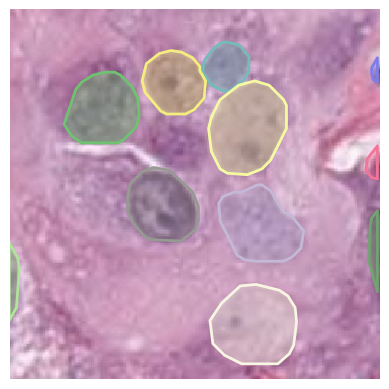

In [23]:
image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
plt.imshow(image, interpolation='nearest')

# Get the ids of the captions
#caption_annotation_ids = coco_captions.getAnnIds(imgIds=image_id)
#print(caption_annotation_ids)
#captions = coco_captions.loadAnns(caption_annotation_ids)
print(img)
cat_ids = val_coco.getCatIds()
anns_ids = val_coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = val_coco.loadAnns(anns_ids)
val_coco.showAnns(anns, draw_bbox=False)
plt.axis(False)
print(f"anno category ids = {[x['category_id'] for x in anns]}")
print(cat_by_id)

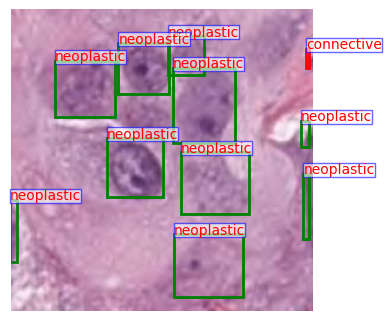

In [24]:
# define a list of colors for drawing bounding boxes
color_list = ["blue", "green", "orange", "red", "blue", "yellow", "black", "pink", "magenta", "aqua"]*10

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
for ann in anns:
    bbox = ann['bbox']
    x, y, w, h = [int(b) for b in bbox]
    class_id = ann["category_id"]
    class_name = val_coco.loadCats(class_id)[0]["name"]
    color_ = color_list[class_id]
    rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')
    t_box=ax.text(x, y, class_name,  color='red', fontsize=10)
    t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
    ax.add_patch(rect)

ax.axis('off')
ax.imshow(image)
#ax[0,0].set_xlabel('Longitude')
plt.tight_layout()
plt.show()

In [25]:
# Predict segmentation results, as well as image captions
result = inference_detector(model, image, with_caption=True, logging=True)[0]

In [26]:
COLOR_PALETTE =[(5, 127, 6), (245, 159, 9), (249, 7, 10),  (0, 0, 255),  (255, 255, 0)]

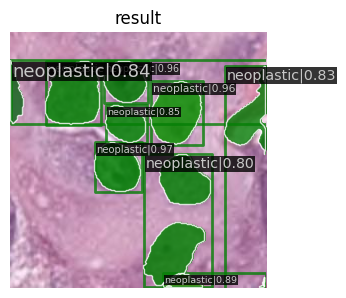

In [28]:
# show the results
show_result_pyplot(model, image, result, score_thr=0.8, palette=COLOR_PALETTE)

In [14]:
result = inference_detector(model, image, with_caption=True, logging=True, grounding_str="connective", candidate_per_im=10)[0]

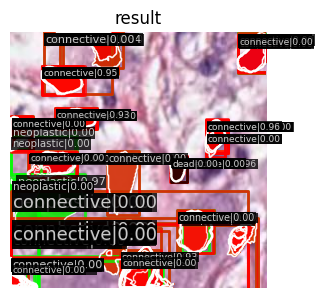

In [19]:
show_result_pyplot(model, image, result, score_thr=-30, palette=COLOR_PALETTE)